# ALS Project - Modeling

### Random Forest Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from regress_model import Linear_Model
from linear_plotting import *
from sklearn.cluster import KMeans

In [3]:
%load_ext autoreload
%autoreload 2

In [161]:
def plot_model_parallel(y_test, y_predicted, units='units'):
    data = pd.DataFrame(y_test.values, columns=["test"])
    data['predicted']=y_predicted
    data['result']='result'
    parallel_coordinates(data, 'result',colormap=plt.get_cmap("Set2"), alpha=0.6)
    plt.title("Results of Model")
    plt.ylabel(units)
    plt.show()

### data = txt, death, riluzole, onset dates, demo

In [88]:
# load data
df = pd.read_csv("clean_data/tdrod.csv")

In [89]:
print(df.shape)
df.head()

(9640, 26)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,...,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days,death_>_1700
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,0,0,NaN,1.0,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,...,1,0,NaN,0,0,NaN,0.0,38.0,13870.0,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,...,0,0,NaN,1,0,NaN,0.0,52.0,18980.0,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,0,0,NaN,1.0,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,0,0,NaN,1.0,NaN,NaN,NaN


### Add scale linear coeff

In [90]:
scale_assess = pd.read_csv("clean_data/scale_assess_slope.csv")

In [91]:
print(scale_assess.shape)
scale_assess.head()

(6537, 4)


,subject_id,scale,slope,intercept
0,329,original,-0.007092,40.084327
1,348,revised,-0.012720,46.428161
2,533,revised,-0.010940,48.231426
3,586,revised,-0.012535,48.000000
4,649,original,-0.020465,43.366399


In [92]:
# merge with previous data
df = df.merge(scale_assess, how='left', on='subject_id')

In [93]:
print(df.shape)
df.head()

(9640, 29)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,...,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days,death_>_1700,scale,slope,intercept
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,...,0,0,NaN,0.0,38.0,13870.0,NaN,original,-0.007092,40.084327
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,...,1,0,NaN,0.0,52.0,18980.0,NaN,revised,-0.012720,46.428161
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


### Add the onset symptom data

In [94]:
symptom = pd.read_csv("clean_data/symptom_onset.csv")

In [95]:
print(symptom.shape)
symptom.head()

(2653, 32)


,subject_id,Symptom,Symptom_Other_Specify,Location,location,right_side,left_side,bilateral_side,loc_general,loc_trunk,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,649,WEAKNESS,NaN,FACIAL,facial,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,649,Speech,NaN,SPEECH,speech,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1234,Speech,NaN,TONGUE WEAKNESS,tongue weakness,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1234,Swallowing,NaN,ORAL PNARYNGIAL WEAKNESS,oral pnaryngial weakness,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2540,WEAKNESS,NaN,RIGHT LEG,right leg,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [96]:
# merge with previous data
df = df.merge(symptom, how='left', on='subject_id')

In [97]:
print(df.shape)
df.head()

(10035, 60)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## clean up the data

In [99]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'Diagnosis_Delta',
       'delta_onset_diag', 'death_day_since_onset', 'death_day_mean_delta',
       'death_week', 'death_month', 'Age', 'Ethnicity',
       'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify',
       'sex', 'age_trial_start_years', 'age_trial_start_days', 'death_>_1700',
       'scale', 'slope', 'intercept', 'Symptom', 'Symptom_Other_Specify',
       'Location', 'location', 'right_side', 'left_side', 'bilateral_side',
       'loc_general', 'loc_trunk', 'loc_face', 'loc_mouth', 'loc_speech',
       'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet', 'loc_hands',
       'loc_arms_or_hands', 'loc_arms_and_legs', 'loc_respiratory',
       'loc_neck_head', 'symptom', 'symptom_atrophy', 'symptom_cramps',
  

In [100]:
# limit to placebo subjects.
placebo = df[ df['Study_Arm']=='Placebo' ].copy()

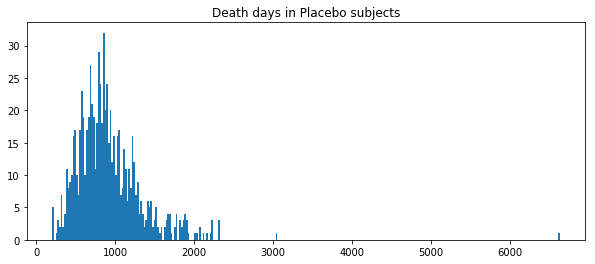

In [101]:
plt.figure(figsize=(10,4))
plt.hist(placebo['death_day_since_onset'], bins = 300)#, edgecolor="white")
plt.title('Death days in Placebo subjects')
plt.show()

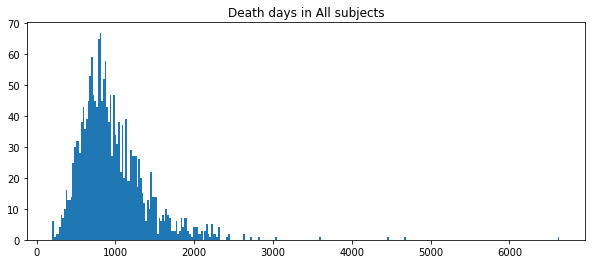

In [102]:
plt.figure(figsize=(10,4))
plt.hist(df['death_day_since_onset'], bins = 300)#, edgecolor="white")
plt.title('Death days in All subjects')
plt.show()

In [103]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'Diagnosis_Delta',
       'delta_onset_diag', 'death_day_since_onset', 'death_day_mean_delta',
       'death_week', 'death_month', 'Age', 'Ethnicity',
       'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify',
       'sex', 'age_trial_start_years', 'age_trial_start_days', 'death_>_1700',
       'scale', 'slope', 'intercept', 'Symptom', 'Symptom_Other_Specify',
       'Location', 'location', 'right_side', 'left_side', 'bilateral_side',
       'loc_general', 'loc_trunk', 'loc_face', 'loc_mouth', 'loc_speech',
       'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet', 'loc_hands',
       'loc_arms_or_hands', 'loc_arms_and_legs', 'loc_respiratory',
       'loc_neck_head', 'symptom', 'symptom_atrophy', 'symptom_cramps',
  

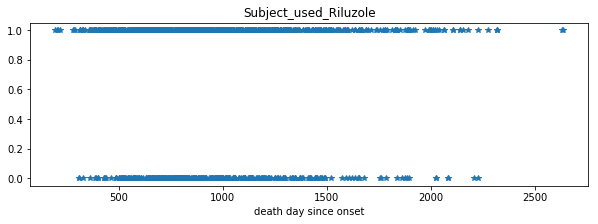

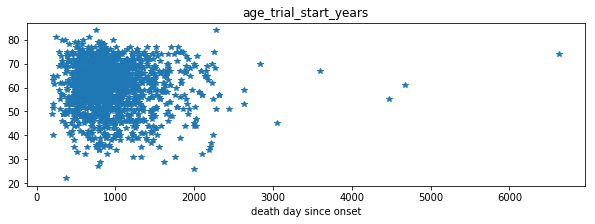

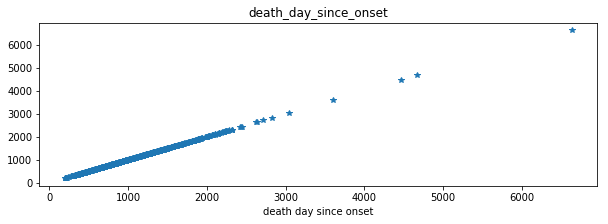

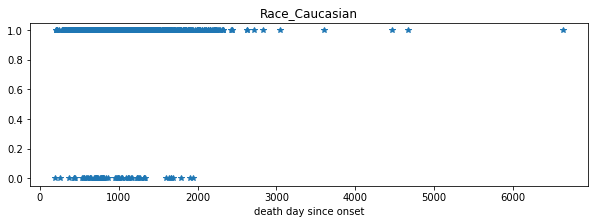

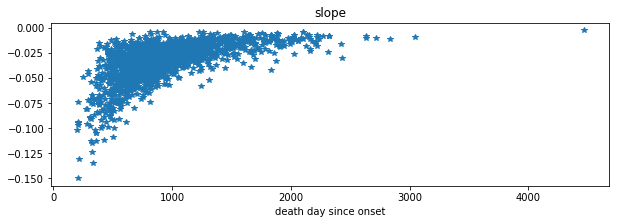

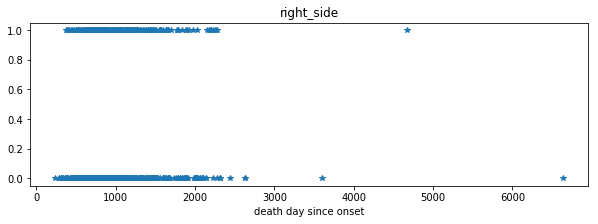

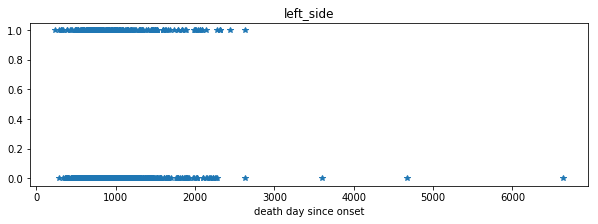

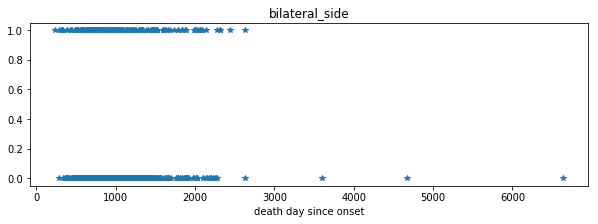

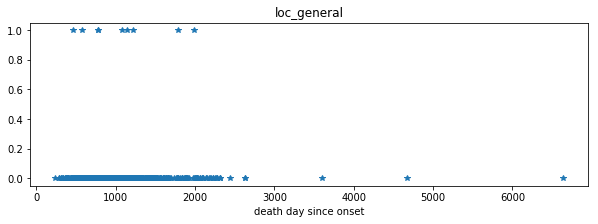

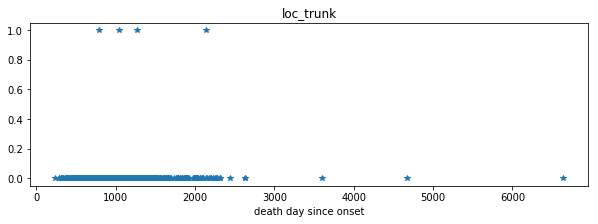

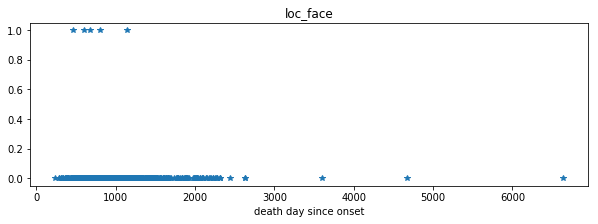

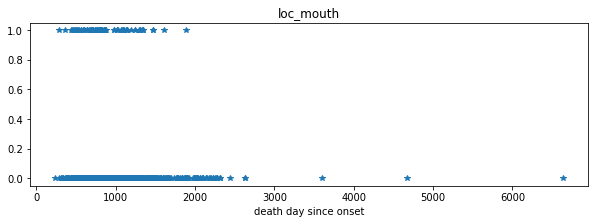

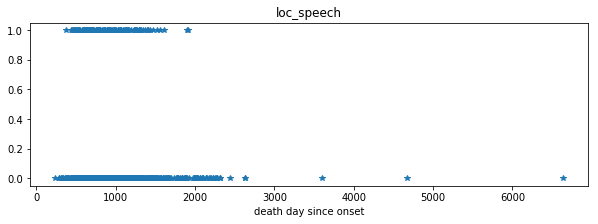

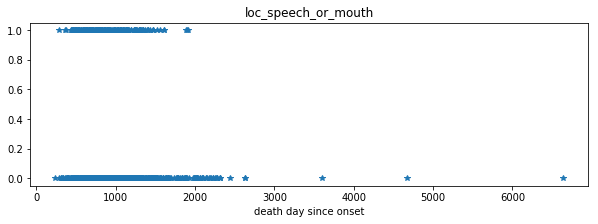

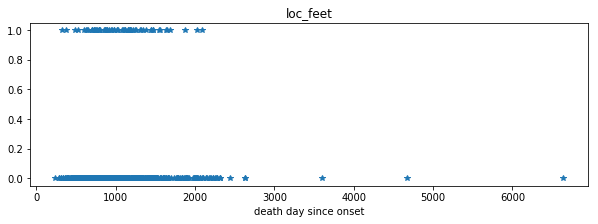

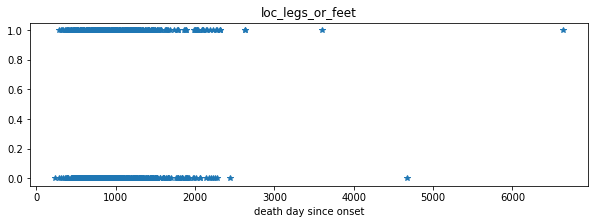

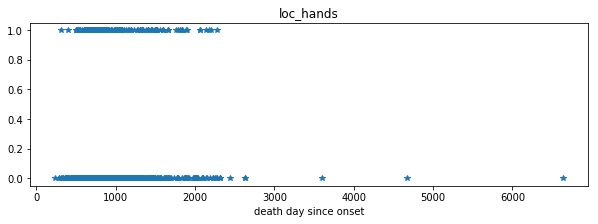

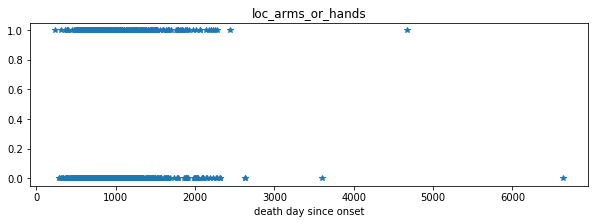

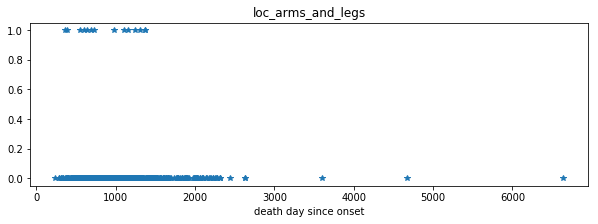

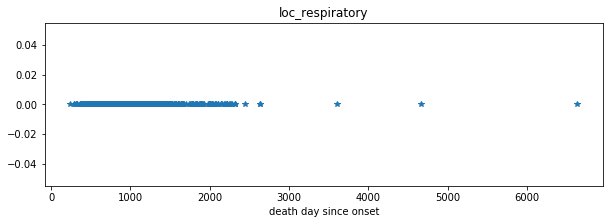

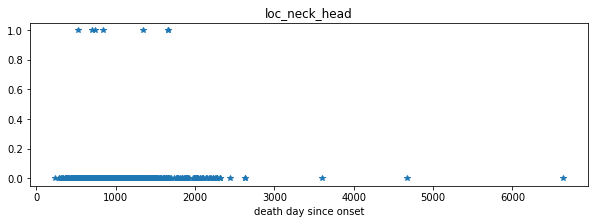

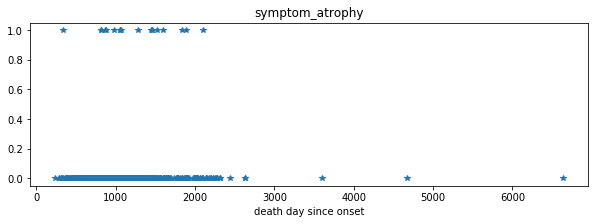

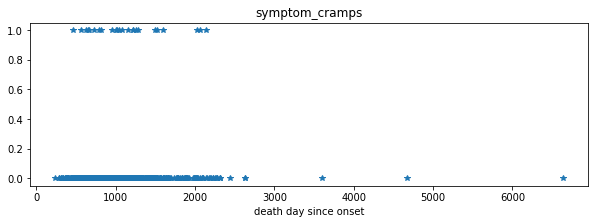

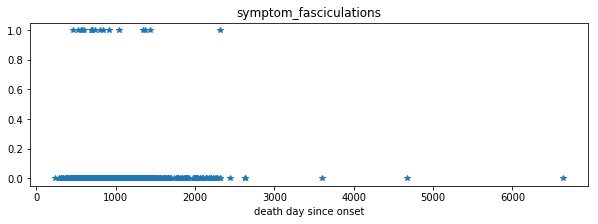

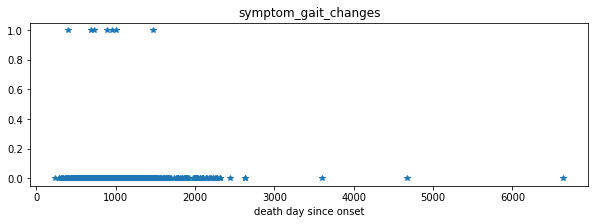

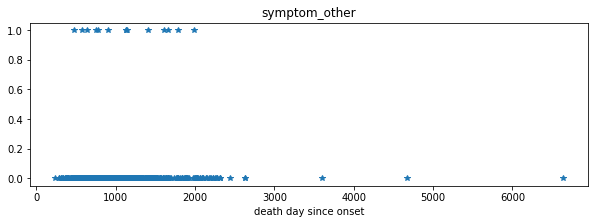

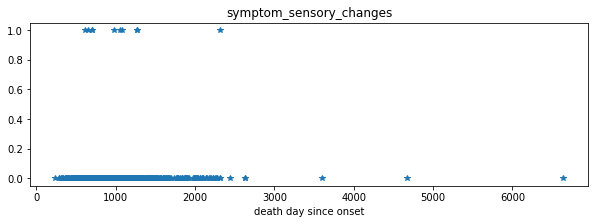

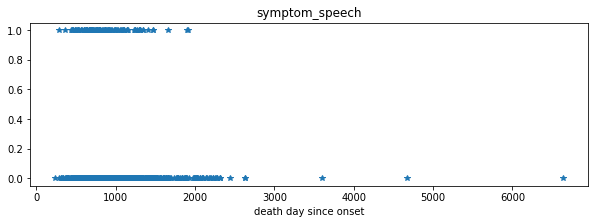

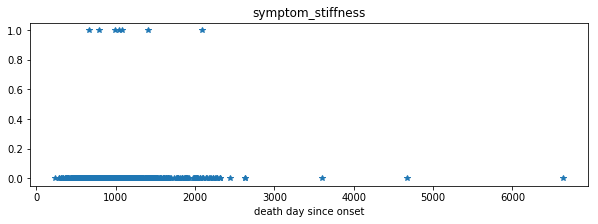

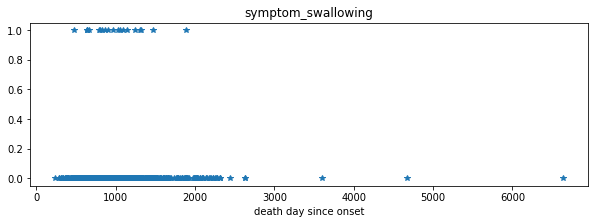

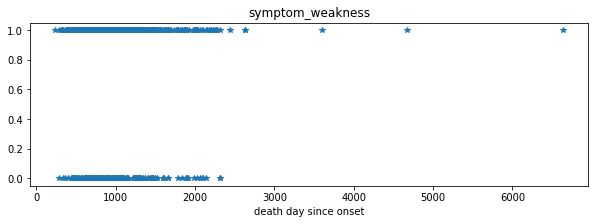

In [105]:
for feat in list(X.columns):
    plt.figure(figsize=(10,3))
    #sns.jointplot(X3['death_day_since_onset'], X3[feat] , kind='scatter')
    plt.plot( X['death_day_since_onset'], X[feat],'*')
    plt.title(feat)
    plt.xlabel("death day since onset")
    plt.show()

### distribution of death days by location

In [106]:
# loc_speech_or_mouth
def plot_feature_by_death(df, col):
    print("Number of subjects: {}".format(len(df[ df[col]==1]['death_day_since_onset'])))
    plt.hist(df[ df[col]==1]['death_day_since_onset'], bins=50,
            ec="white")
    plt.title(col)
    plt.xlim(0,4000)
    plt.axvline(1800, color="red")
    plt.show()
    mean_death = df[ df[col]==1]['death_day_since_onset'].mean()
    print("mean day from onset to death = {}".format(mean_death))
    return mean_death

Number of subjects: 506


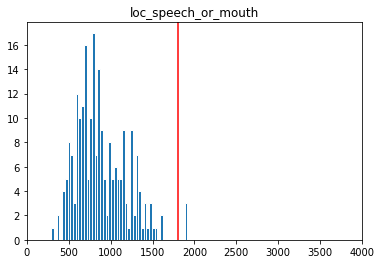

mean day from onset to death = 884.2643171806168


In [107]:
speech_mouth = plot_feature_by_death(df, 'loc_speech_or_mouth')

Number of subjects: 168


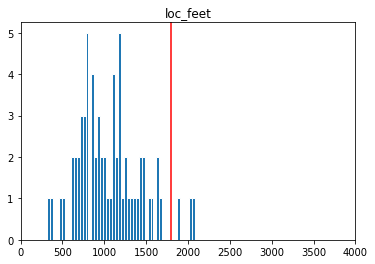

mean day from onset to death = 1056.3636363636363


In [108]:
feet = plot_feature_by_death(df, 'loc_feet')

Number of subjects: 950


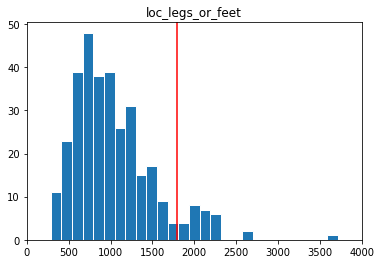

mean day from onset to death = 1057.8176291793313


In [109]:
legs_or_feet = plot_feature_by_death(df, 'loc_legs_or_feet')

Number of subjects: 50


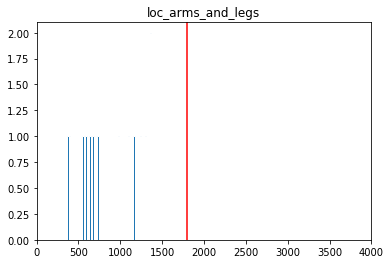

mean day from onset to death = 890.1428571428571


In [110]:
arms_and_legs = plot_feature_by_death(df, 'loc_arms_and_legs')

Number of subjects: 547


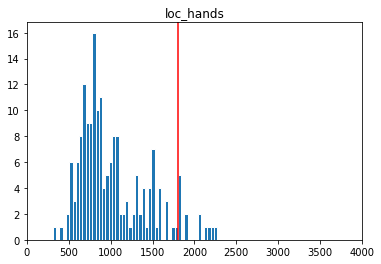

mean day from onset to death = 1025.6795580110497


In [111]:
hands = plot_feature_by_death(df, 'loc_hands')

### Prepare df for model

In [123]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'Diagnosis_Delta',
       'delta_onset_diag', 'death_day_since_onset', 'death_day_mean_delta',
       'death_week', 'death_month', 'Age', 'Ethnicity',
       'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify',
       'sex', 'age_trial_start_years', 'age_trial_start_days', 'death_>_1700',
       'scale', 'slope', 'intercept', 'Symptom', 'Symptom_Other_Specify',
       'Location', 'location', 'right_side', 'left_side', 'bilateral_side',
       'loc_general', 'loc_trunk', 'loc_face', 'loc_mouth', 'loc_speech',
       'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet', 'loc_hands',
       'loc_arms_or_hands', 'loc_arms_and_legs', 'loc_respiratory',
       'loc_neck_head', 'symptom', 'symptom_atrophy', 'symptom_cramps',
  

In [139]:
# columns not the include
drop_demo = ['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
        'Onset_Delta', 'Diagnosis_Delta', 'delta_onset_diag']
drop_death = ['death_day_mean_delta', 'death_week', 'death_month', 'death_>_1700']
drop_race = ['Ethnicity', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian', 
             'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander', 
             'Race_Unknown', 'Race_Other', 'Race_Other_Specify']
drop_other = ['scale', 'intercept', 'Symptom', 'Symptom_Other_Specify', 
             'Location', 'location', 'symptom']

In [145]:
# select the features to include in model.
model_data = df.copy()
drop_list = drop_demo + drop_death + drop_race + drop_other
model_data.drop(drop_list, axis=1, inplace=True)

In [146]:
print(model_data.shape)
model_data.head(50)

(10035, 34)


,Subject_used_Riluzole,death_day_since_onset,Age,Race_Caucasian,sex,age_trial_start_years,age_trial_start_days,slope,right_side,left_side,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,1.0,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,38.0,0,0.0,38.0,13870.0,-0.007092,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,52.0,1,0.0,52.0,18980.0,-0.012720,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,NaN,48.0,1,0.0,48.0,17520.0,-0.020465,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,1.0,NaN,48.0,1,0.0,48.0,17520.0,-0.020465,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,NaN,1320.0,46.0,1,1.0,46.0,16790.0,-0.006526,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,NaN,76.8,1,0.0,76.8,28032.0,-0.014862,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,NaN,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
model_data.dropna(axis=0, inplace=True)

In [148]:
print(model_data.shape)
model_data.head()

(788, 34)


,Subject_used_Riluzole,death_day_since_onset,Age,Race_Caucasian,sex,age_trial_start_years,age_trial_start_days,slope,right_side,left_side,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
24,1.0,405.0,41.0,1,1.0,41.0,14965.0,-0.053054,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34,1.0,624.0,60.0,1,0.0,60.0,21900.0,-0.037167,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36,0.0,825.0,69.0,1,0.0,69.0,25185.0,-0.011764,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50,1.0,585.0,68.0,1,1.0,68.0,24820.0,-0.025766,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
68,1.0,656.0,70.0,1,1.0,70.0,25550.0,-0.012011,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### split data

In [149]:
# assign target, features
y = model_data['death_day_since_onset']
X = model_data.drop('death_day_since_onset', axis=1)

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)


#### Random Forest 

In [153]:
model = RandomForestRegressor()
model.fit(X_train,y_train)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [154]:
# score - R2
model.score(X_test, y_test.values)

0.5823943151505641

In [157]:
#rf regressor model
# performs splits within class
params = {'criterion':'mse', 'random_state':1234}
lm = Linear_Model('random', X, y, params=params)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [158]:
lm.score

0.6289583121515039

In [159]:
# predicted y values
y_predicted = model.predict(X_test)

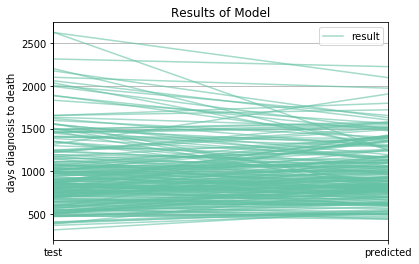

In [162]:
# plot the 
plot_model_parallel(y_test, y_predicted, 'days diagnosis to death')

In [163]:
# overview of test and predict data
data = pd.DataFrame(y_test.values, columns=["test"])
data['predicted']=y_predicted
data['result']='result'
print(data.shape)
data.head(10)

(197, 3)


,test,predicted,result
0,501.0,691.6,result
1,742.0,688.6,result
2,1001.0,759.2,result
3,1493.0,1575.5,result
4,1077.0,812.1,result
5,971.0,1125.1,result
6,865.0,1163.5,result
7,547.0,490.7,result
8,702.0,740.0,result
9,644.0,608.2,result


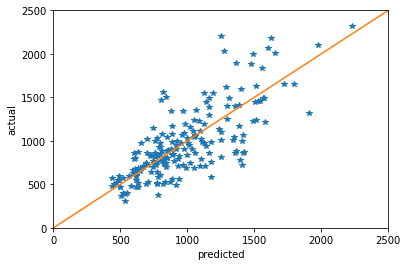

In [164]:
plt.plot(data['predicted'], data['test'], '*')
plt.ylabel("actual")
plt.xlabel("predicted")
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.plot([0,2500], [0,2500])

In [165]:
# plot feature importances

## Linear Model

In [167]:
params = {'a':1}
lm = Linear_Model('linear', X, y, params)

/Users/Shared/galvanize/als/regress_model.py:233: RuntimeWarning: invalid value encountered in log
  self.rmse_log = np.sqrt(((( np.log(self.predicted+1)-np.log(self.y_train + 1) )**2).sum() ) / len(self.y_train))


In [168]:
lm.rmse

291.88771630785067

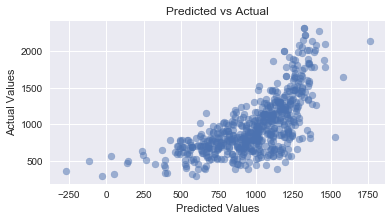

In [169]:
lm_plot(lm.predicted, lm.y_train)

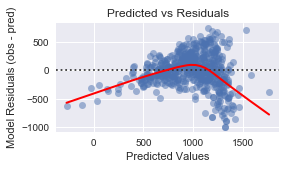

In [170]:
resid_plot(lm.predicted, lm.resid)

### Cluster analysis

In [172]:
model_data.columns

Index(['Subject_used_Riluzole', 'death_day_since_onset', 'Age',
       'Race_Caucasian', 'sex', 'age_trial_start_years',
       'age_trial_start_days', 'slope', 'right_side', 'left_side',
       'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face', 'loc_mouth',
       'loc_speech', 'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet',
       'loc_hands', 'loc_arms_or_hands', 'loc_arms_and_legs',
       'loc_respiratory', 'loc_neck_head', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'symptom_swallowing', 'symptom_weakness'],
      dtype='object')

In [173]:
# pick a limited number of columns from df

cluster_X = model_data.copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(788, 34)


,Subject_used_Riluzole,death_day_since_onset,Age,Race_Caucasian,sex,age_trial_start_years,age_trial_start_days,slope,right_side,left_side,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,1.0,405.0,41.0,1,1.0,41.0,14965.0,-0.053054,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,624.0,60.0,1,0.0,60.0,21900.0,-0.037167,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,825.0,69.0,1,0.0,69.0,25185.0,-0.011764,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,585.0,68.0,1,1.0,68.0,24820.0,-0.025766,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,656.0,70.0,1,1.0,70.0,25550.0,-0.012011,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [174]:
cluster_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 34 columns):
Subject_used_Riluzole      788 non-null float64
death_day_since_onset      788 non-null float64
Age                        788 non-null float64
Race_Caucasian             788 non-null int64
sex                        788 non-null float64
age_trial_start_years      788 non-null float64
age_trial_start_days       788 non-null float64
slope                      788 non-null float64
right_side                 788 non-null float64
left_side                  788 non-null float64
bilateral_side             788 non-null float64
loc_general                788 non-null float64
loc_trunk                  788 non-null float64
loc_face                   788 non-null float64
loc_mouth                  788 non-null float64
loc_speech                 788 non-null float64
loc_speech_or_mouth        788 non-null float64
loc_feet                   788 non-null float64
loc_legs_or_feet           788 no

In [175]:
params = {'n_clusters':2, 'init':'k-means++', 'n_init':10, 'max_iter':300, 
          'tol':0.0001, 'precompute_distances':'auto', 'verbose':0, 
          'random_state':None, 'copy_x':True, 'n_jobs':None, 'algorithm':'auto'}

k=KMeans(**params).fit(cluster_X)

In [176]:
result = pd.DataFrame(k.labels_, columns=["kmeans_label"])
cluster_result = pd.concat([cluster_X, result], axis=1)
cluster_result.head()

,Subject_used_Riluzole,death_day_since_onset,Age,Race_Caucasian,sex,age_trial_start_years,age_trial_start_days,slope,right_side,left_side,...,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness,kmeans_label
0,1.0,405.0,41.0,1,1.0,41.0,14965.0,-0.053054,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,1.0,624.0,60.0,1,0.0,60.0,21900.0,-0.037167,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,0.0,825.0,69.0,1,0.0,69.0,25185.0,-0.011764,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,1.0,585.0,68.0,1,1.0,68.0,24820.0,-0.025766,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,1.0,656.0,70.0,1,1.0,70.0,25550.0,-0.012011,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


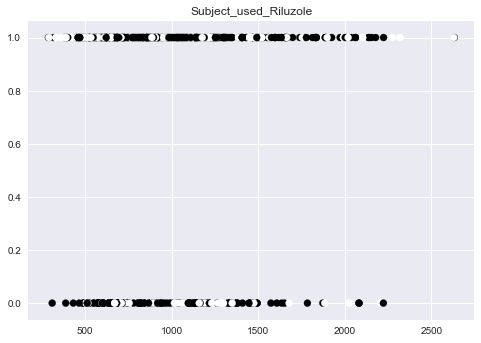

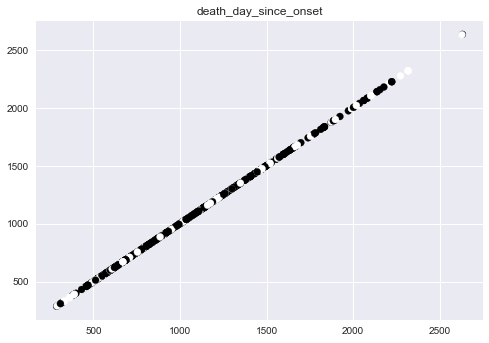

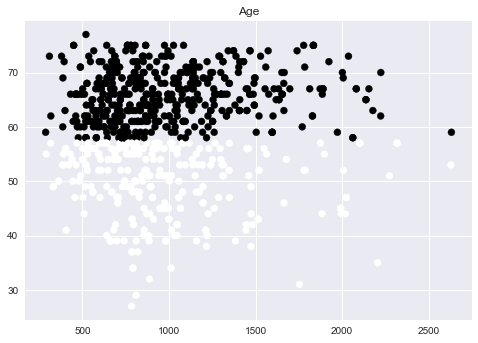

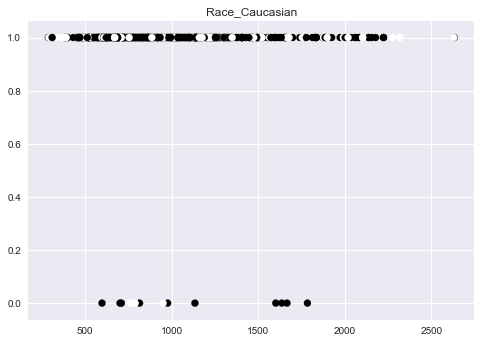

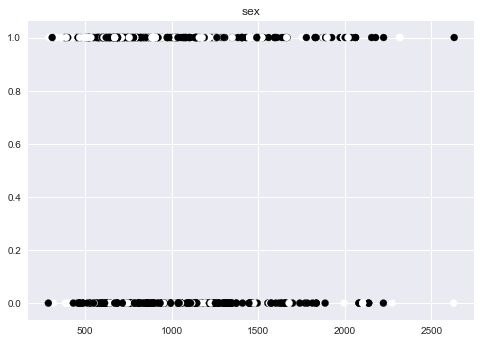

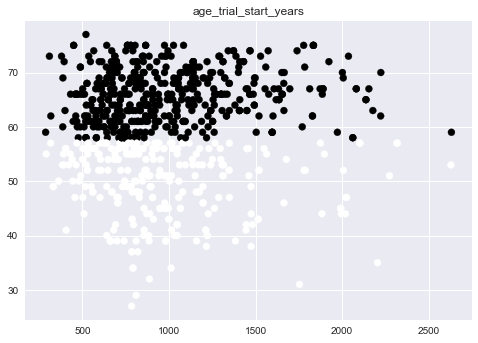

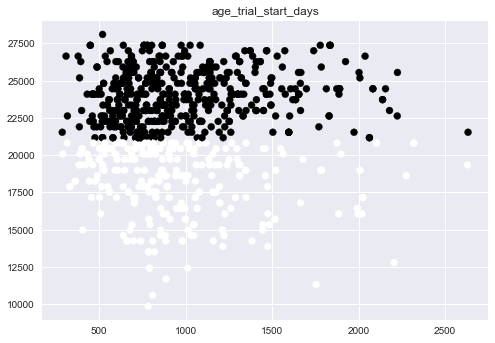

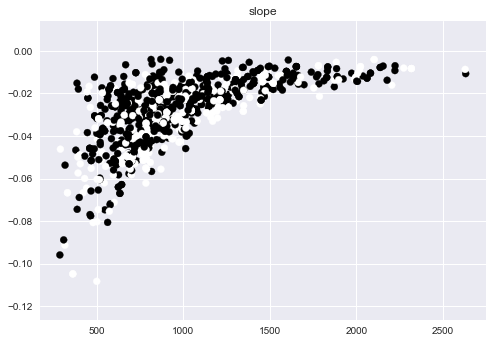

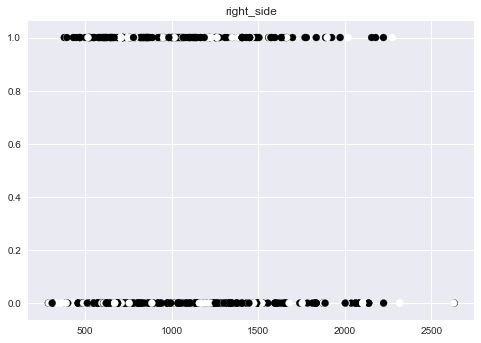

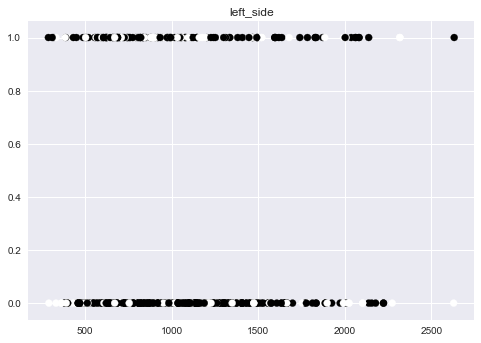

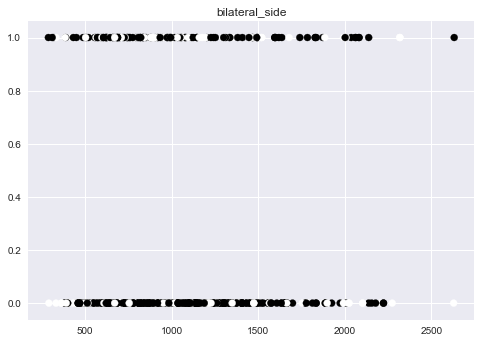

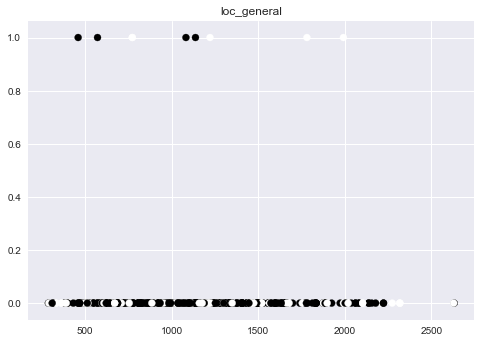

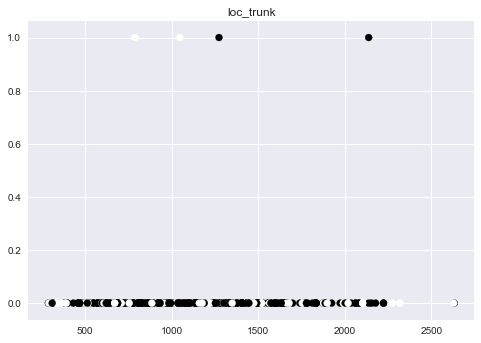

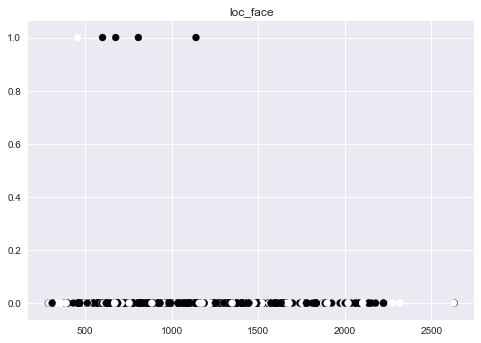

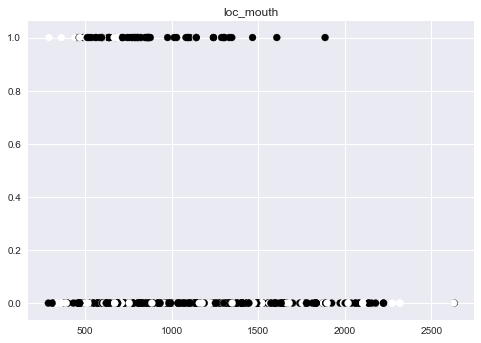

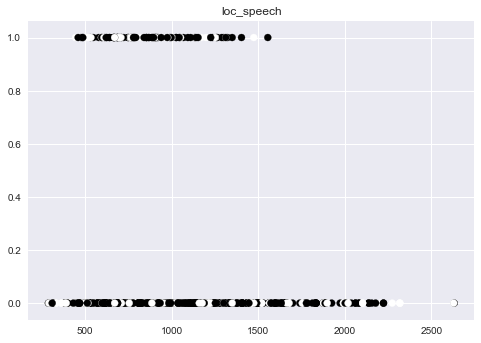

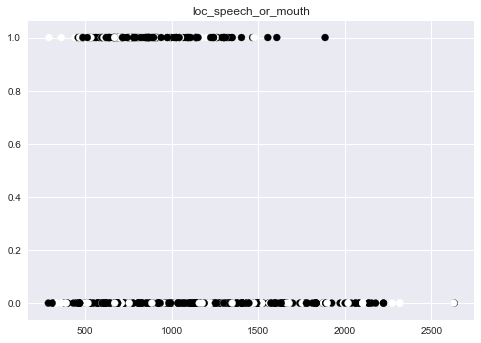

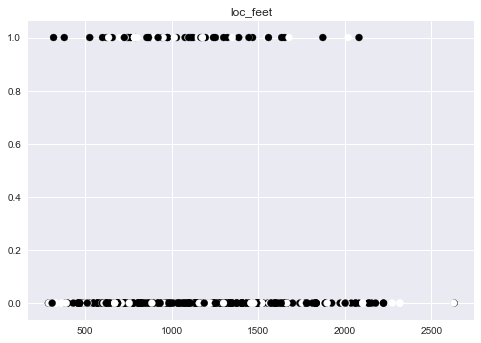

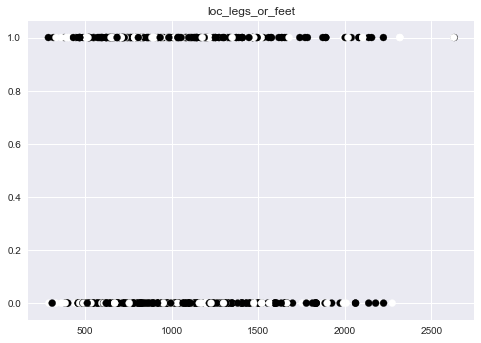

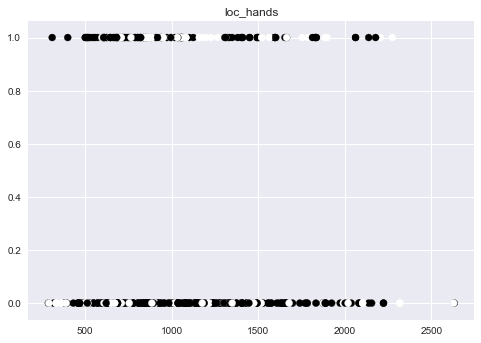

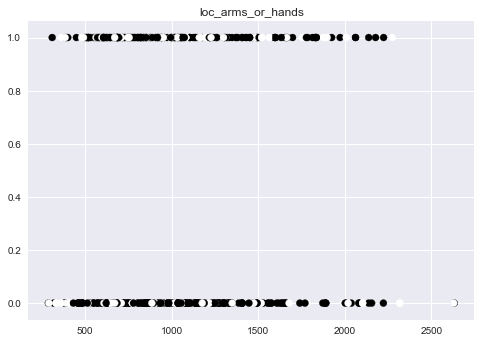

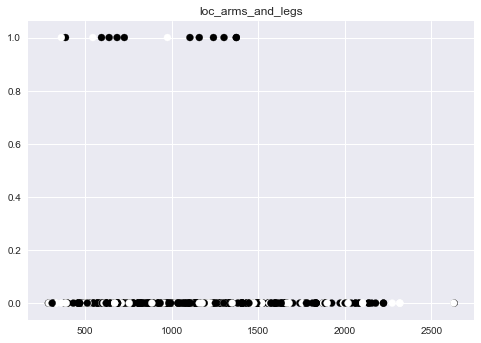

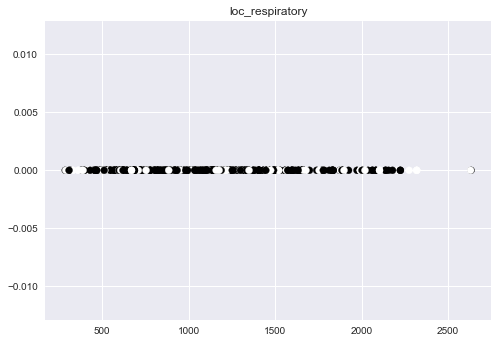

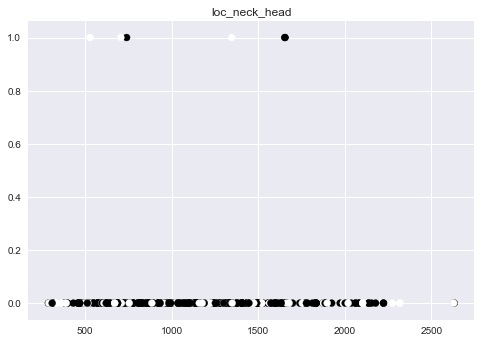

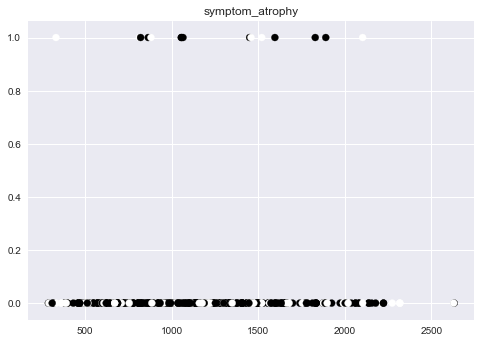

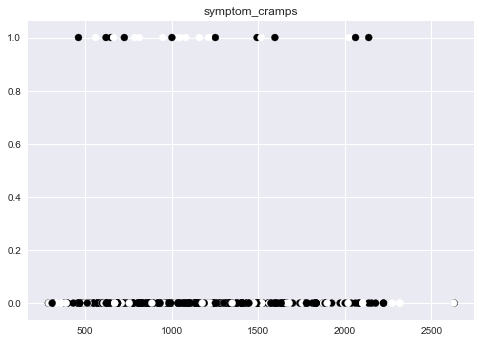

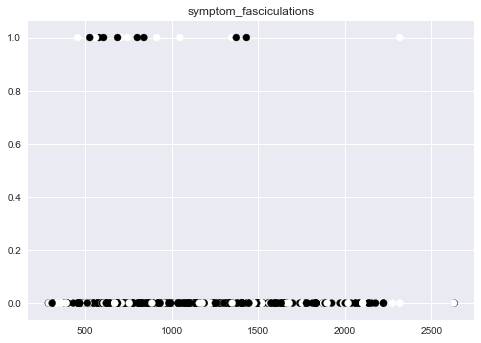

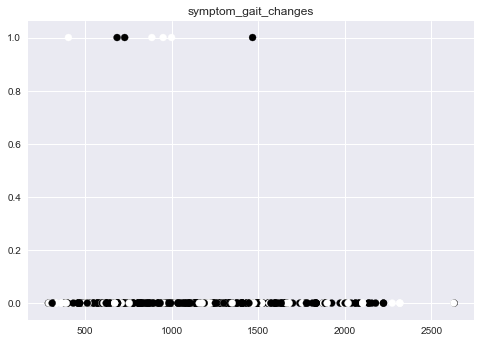

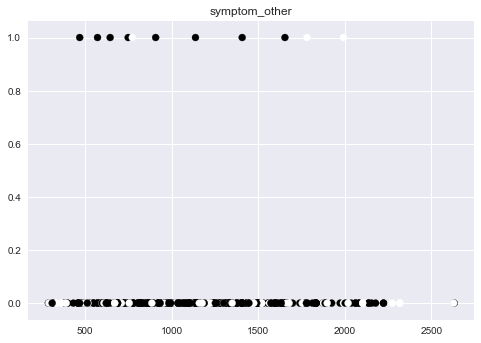

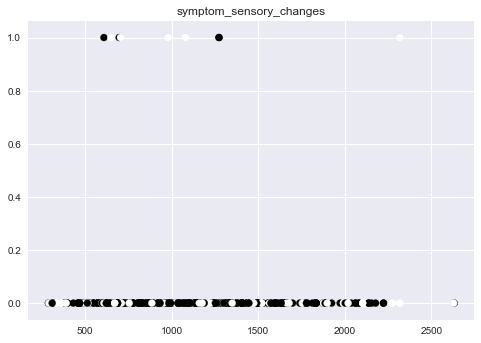

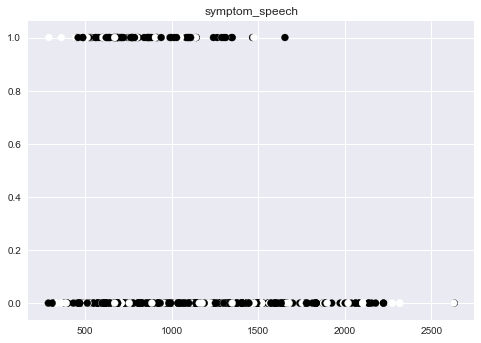

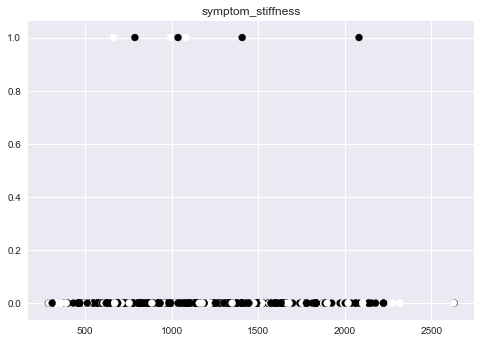

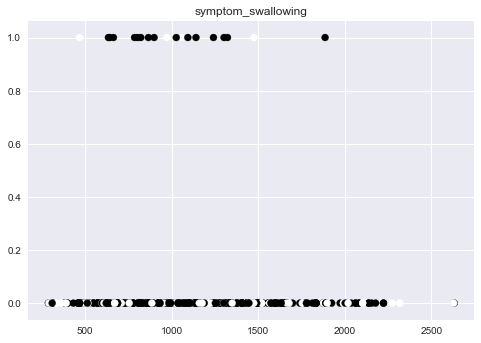

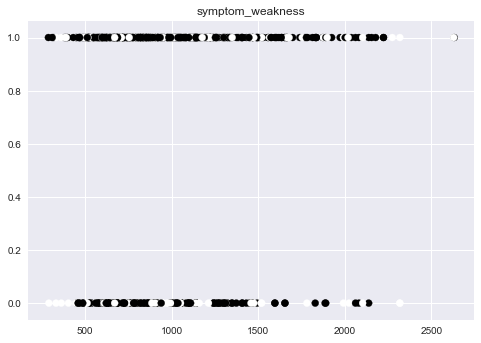

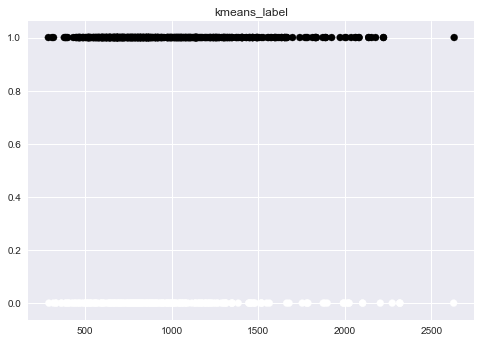

In [177]:
# plot the labels for each feature

for col in list(cluster_result.columns):
    plt.scatter(cluster_result['death_day_since_onset'], cluster_result[col], 
                c=cluster_result['kmeans_label'])
    plt.title(col)
    plt.show()